# 1. IMPORTING PACKAGES & LOADING DATASETS 


## 1.1 Import library

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from pylab import rcParams # access and change Matplotlib's controll parameters to customize plots
sns.set(color_codes=True)        
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
plot_params = dict(color="0.75", style=".-",markeredgecolor="0.25", markerfacecolor="0.25", legend=False)

import time
from itertools import product # used to create Descartes

# provides tools to build defined processes, especially useful in time series analysis
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier
'''
@ CalendarFourier:      use to generate Fourier components for calendar periods such as weeks, months, or years
@ DeterministicProcess: main framwork for creating deterministic components such as trends, seasonality, and Fourier components
@ Fourier:              generate general Fourier components for non-specific periods
'''
path='../input/store-sales-time-series-forecasting/'

from warnings import simplefilter
simplefilter('ignore')

/tmp/ipykernel_18/3940146533.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## 1.2 Import model

In [2]:
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

## 1.3 Loading Data

In [3]:
'''
import os
for dirname ,_ ,filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
datafolder = "../input/store-sales-time-series-forecasting/"
'''

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [4]:
oil = pd.read_csv(("oil.csv"), parse_dates=['date'], infer_datetime_format= True)
hols_eves = pd.read_csv(("holidays_events.csv"), parse_dates=['date'], infer_datetime_format= True)
stores = pd.read_csv(("stores.csv"))
train = pd.read_csv(("train.csv"), parse_dates=['date'], infer_datetime_format= True)
test = pd.read_csv(("test.csv"), parse_dates=['date'], infer_datetime_format= True)
transactions = pd.read_csv(("transactions.csv"), parse_dates=['date'], infer_datetime_format= True)

# 2. Visualize dataset

In [6]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [7]:
test.tail()

,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


In [8]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [9]:
def info(df):
    """
    This defination will define to print most valuable information about dataset columns.
    Input: df (dataset)
    Output: df columns information
    """
    display(df.head())
    display(df.info())
    
    print(f'Dataset have: {df.columns.value_counts} columns \n\n')
    
    for col in df.columns:
        print(f'==========={col}===========')
        print('Type is: ', df[col].dtype)
        print(df[col].value_counts())
        print(f'Number of unique values of {col}: {df[col].nunique()}')
        print(f'Number of null values of {col}: {df[col].isna().sum()}\n\n\n')

## 2.1 TRAIN

In [10]:
info(train)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


None

Dataset have: <bound method IndexOpsMixin.value_counts of Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')> columns 


===========id===========
Type is:  int64
id
0          1
2000584    1
2000586    1
2000587    1
2000588    1
          ..
1000298    1
1000299    1
1000300    1
1000301    1
3000887    1
Name: count, Length: 3000888, dtype: int64
Number of unique values of id: 3000888
Number of null values of id: 0



===========date===========
Type is:  datetime64[ns]
date
2013-01-01    1782
2016-01-15    1782
2016-02-08    1782
2016-02-07    1782
2016-02-06    1782
              ... 
2014-07-13    1782
2014-07-12    1782
2014-07-11    1782
2014-07-10    1782
2017-08-15    1782
Name: count, Length: 1684, dtype: int64
Number of unique values of date: 1684
Number of null values of date: 0



===========store_nbr===========
Type is:  int64
store_nbr
1     55572
46    55572
36    55572
37    55572
38    55572
39    55572
4     55572
40    55572
41    55

The sale variables is highly positive skewness, the given distribution is shifted to the left and with its tail on the right side.
- There are few values signigicantly higher than the mean, but these values do not occur frequently

### 2.1.1 Memory Usage Reduce

The memory usage of train df is pretty large, we can reduce it by some data type conversions like:
- Convert dtype for [id] from "int64" to "int32"
- Convert dtype for [store_nbr] from "int64" to "int8"
- Convert dtype for [family] from "object" to "category"
- Convert dtype for [sale] from "float64" to "float32"
- Convert dtype for [onpromotion] from "int64" to "int16"

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [12]:
train['id'] = train.id.astype('int32')
train['store_nbr'] = train.store_nbr.astype("int8")
train['family'] = train.family.astype('category')
train['sales'] = train.sales.astype('float32')
train['onpromotion'] = train.onpromotion.astype('int16')

display(train.info(verbose=False, memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Columns: 6 entries, id to onpromotion
dtypes: category(1), datetime64[ns](1), float32(1), int16(1), int32(1), int8(1)
memory usage: 57.2 MB


None

+ Indeed, we succed to reduce the memory usage from 137M to 57 MB (more than half) whis will be reflected in speed processing especially for EDA task.

skewness of saless: 7.358758


count    3.000888e+06
mean     3.577758e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

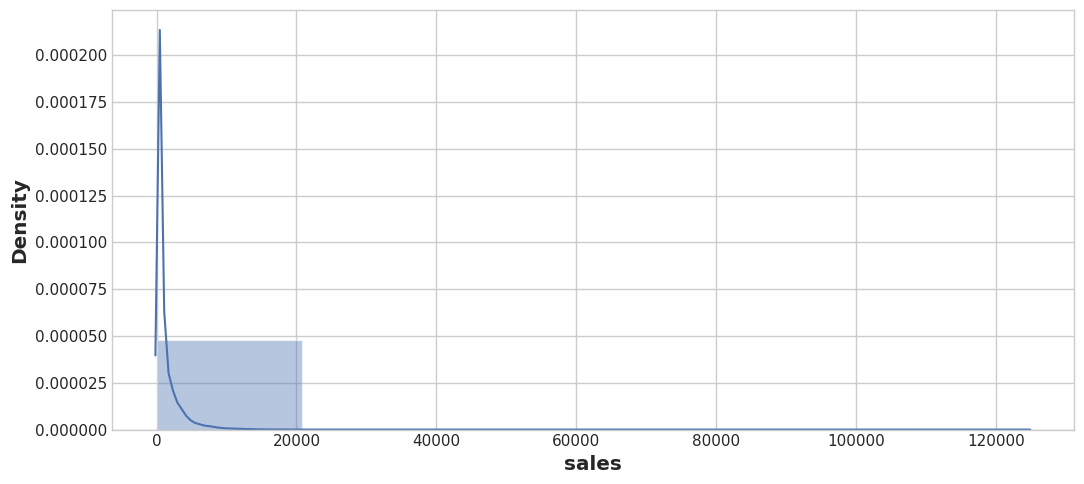

In [13]:
# Skewness of sales
print('skewness of saless:', train['sales'].skew())

display(train['sales'].describe())

sns.distplot(train['sales'],bins=6)
plt.show()

## 2.1.2 Avg Sales by time

In [14]:
train_eda = train.copy() # initializing a copy of train dataset for EDA purpose

train_eda = train_eda.set_index('date') # setting date to index for simple handling

# resample sales by day
daily_sales = train_eda.resample('D').sales.mean().to_frame()

# resample sales by week
weely_sales = train_eda.resample('W').sales.mean().to_frame()

# resample sales by month
monthly_sales = train_eda.resample('M').sales.mean().to_frame()

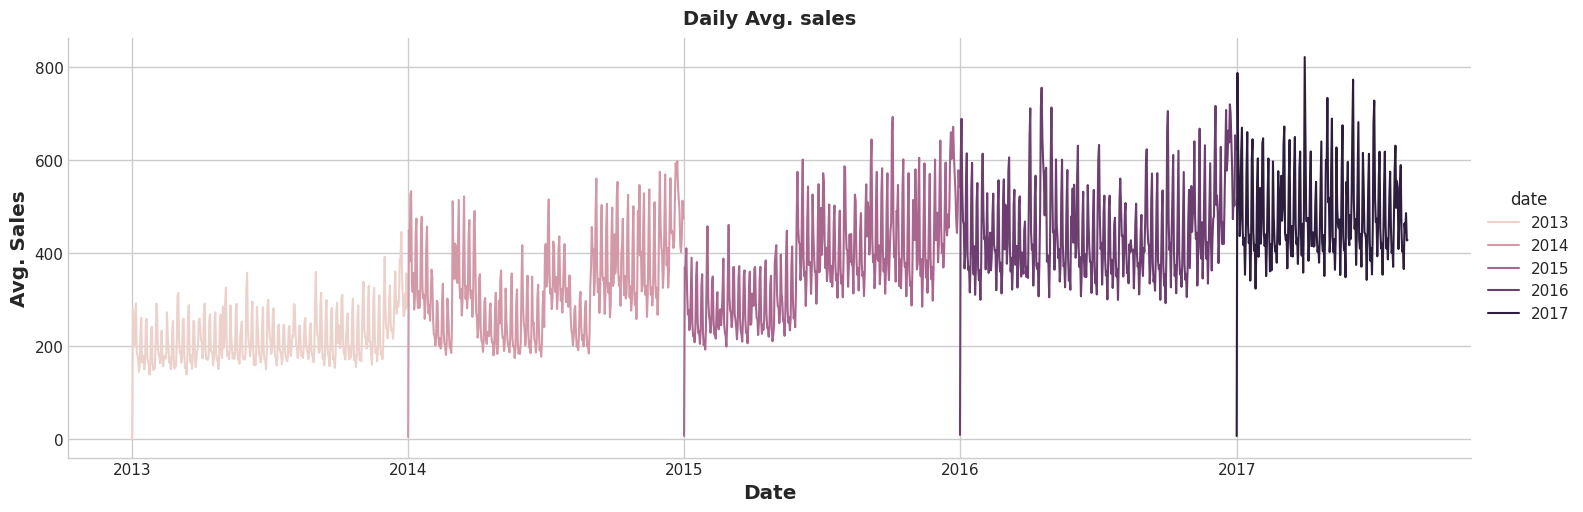

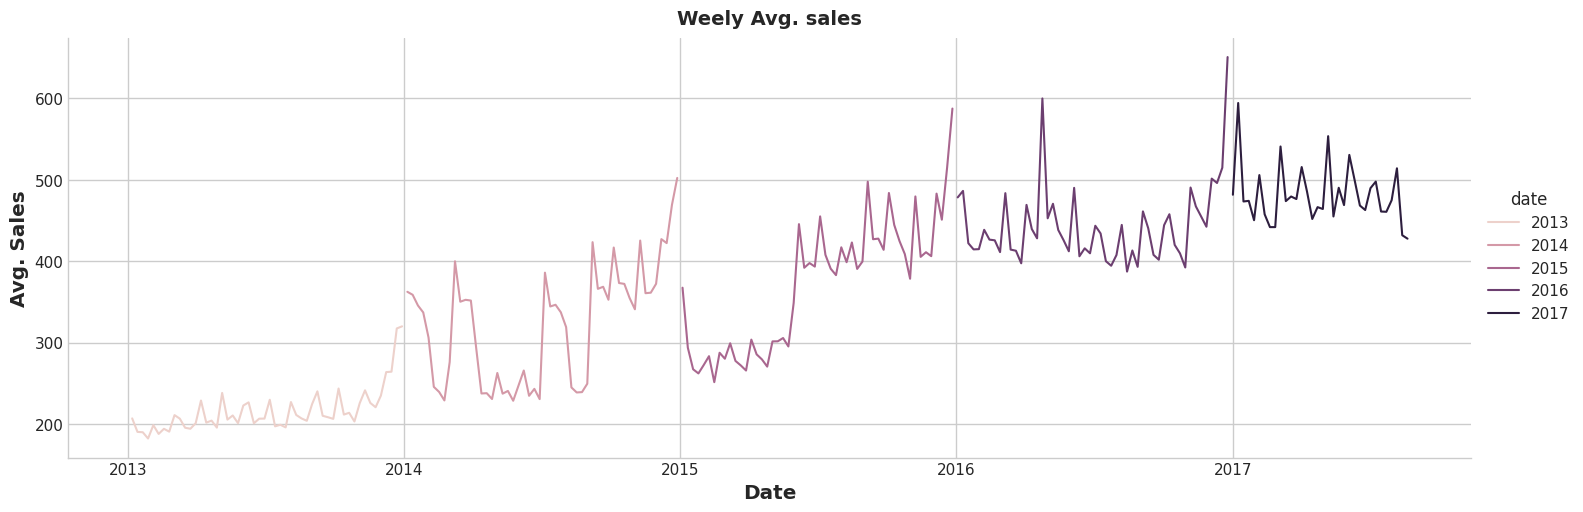

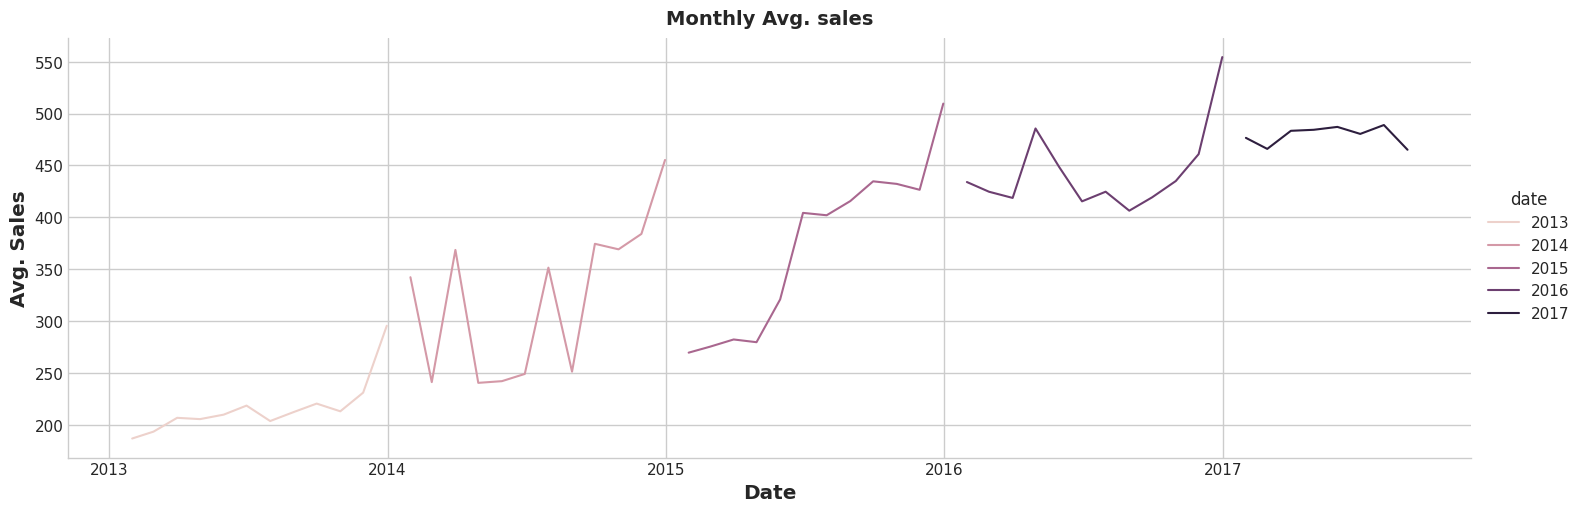

In [15]:
df_timeline = [daily_sales, weely_sales, monthly_sales]
title_timeline = ['Daily Avg. sales', 'Weely Avg. sales', 'Monthly Avg. sales']

for i,j in zip(df_timeline, title_timeline):
    sns.relplot(x=i.index , y=i.sales, kind='line', aspect=3, hue=i.index.year)
    plt.xlabel('Date')
    plt.ylabel('Avg. Sales')
    plt.title(j)
    
plt.show()

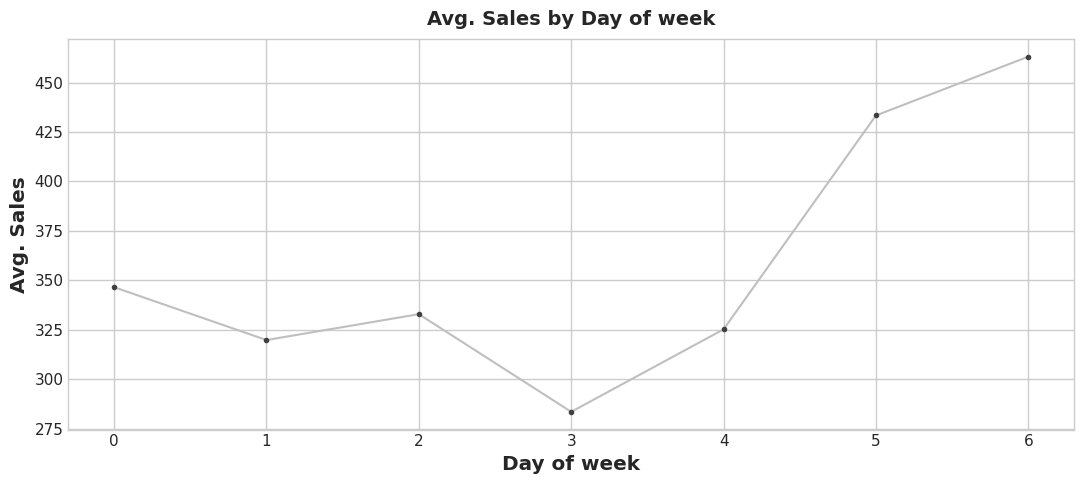

In [16]:
# Group by day of week

temp = train_eda.groupby(train_eda.index.day_of_week)['sales'].mean().to_frame()

temp.plot(**plot_params)
plt.xlabel('Day of week')
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales by Day of week')
plt.show()

- Sales are increased at annual basis, that indicates a trend variables
- There are peaks at daily / weekly basis at weekends, that indicates a seasonality variable 
- A zero sales at each start of a year can be shown from "Daily Avg. Sales", due to Favourite Supermarkets chain were closed at that days.
- Generally, sales on Thursdays are smaller than rest of days.

### 2.1.3 Total Sales vs On Promotion
<code>onpromotion</code>: gives the total number of items in a product family that were being promoted at a store at a given date.

The correlation between sales & onpromotion is:  0.5749 



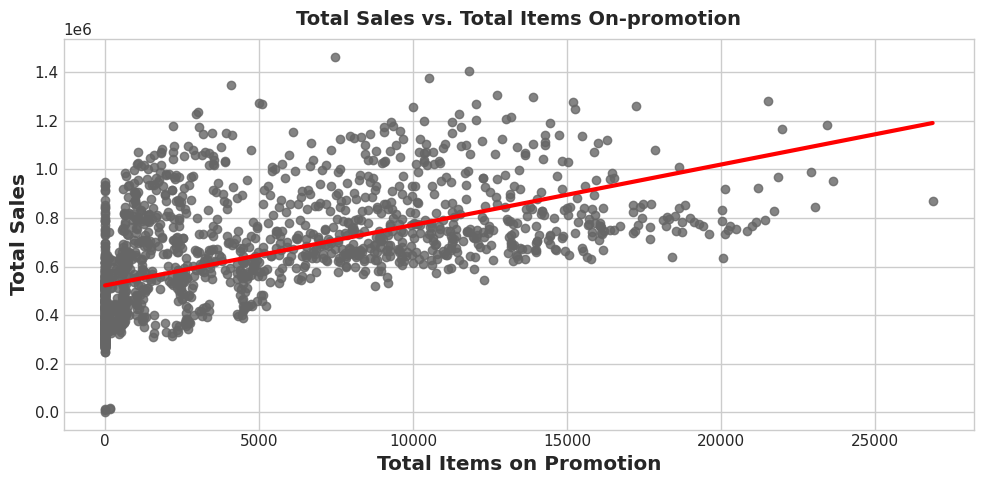

In [17]:
# check the correlation between the sales and onpromotion
avg_sales=train_eda.groupby(['date'])[['sales','onpromotion']].sum().reset_index()

print('The correlation between sales & onpromotion is: ',
      np.round(avg_sales[['sales','onpromotion']].corr().iloc[0,1],4),'\n')

plt.figure(figsize=(10,5))
sns.regplot(data=avg_sales,x='onpromotion',y='sales',ci=None,
            scatter_kws={'color':'0.4'},line_kws={'color':'red','linewidth':3})
plt.xlabel('Total Items on Promotion')
plt.ylabel('Total Sales')
plt.title('Total Sales vs. Total Items On-promotion')
plt.show()

- Positive correlation between onpromotion and sales units sold. Thus, when more items are on promotion, it's more likely to sell them.

### 2.1.4 Avg Sales by Family Products
family identifies the type of product sold.

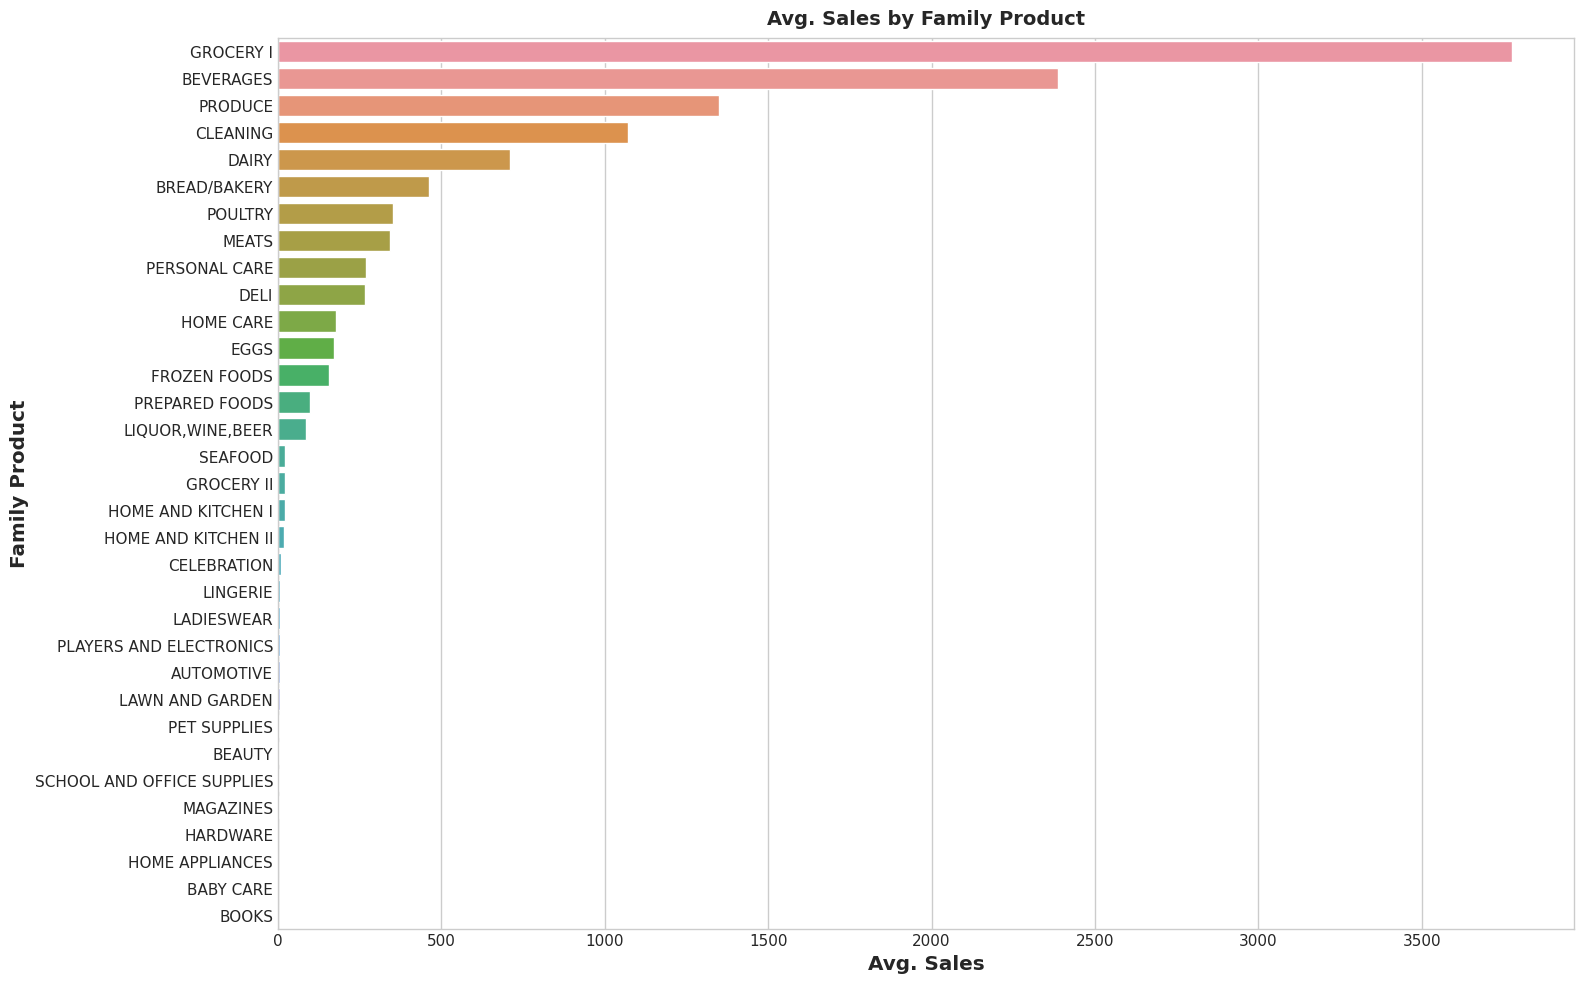

The best family products sell are:  ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY']

The worst family products sell are:  ['MAGAZINES', 'HARDWARE', 'HOME APPLIANCES', 'BABY CARE', 'BOOKS']


In [18]:
temp=train_eda.groupby('family')['sales'].mean().sort_values(ascending=False).to_frame()

plt.figure(figsize=(16,10))
sns.barplot(data=temp,x=temp.sales,y=temp.index,ci=None,order=list(temp.index))
plt.xlabel('Avg. Sales')
plt.ylabel('Family Product')
plt.title('Avg. Sales by Family Product')
plt.show()

print('The best family products sell are: ',list(temp.index[:5]))
print('\nThe worst family products sell are: ',list(temp.index[-5:]))

### 2.1.5 Avg Sales by Store No.
store_nbr: identifies the store at which the products are sold.


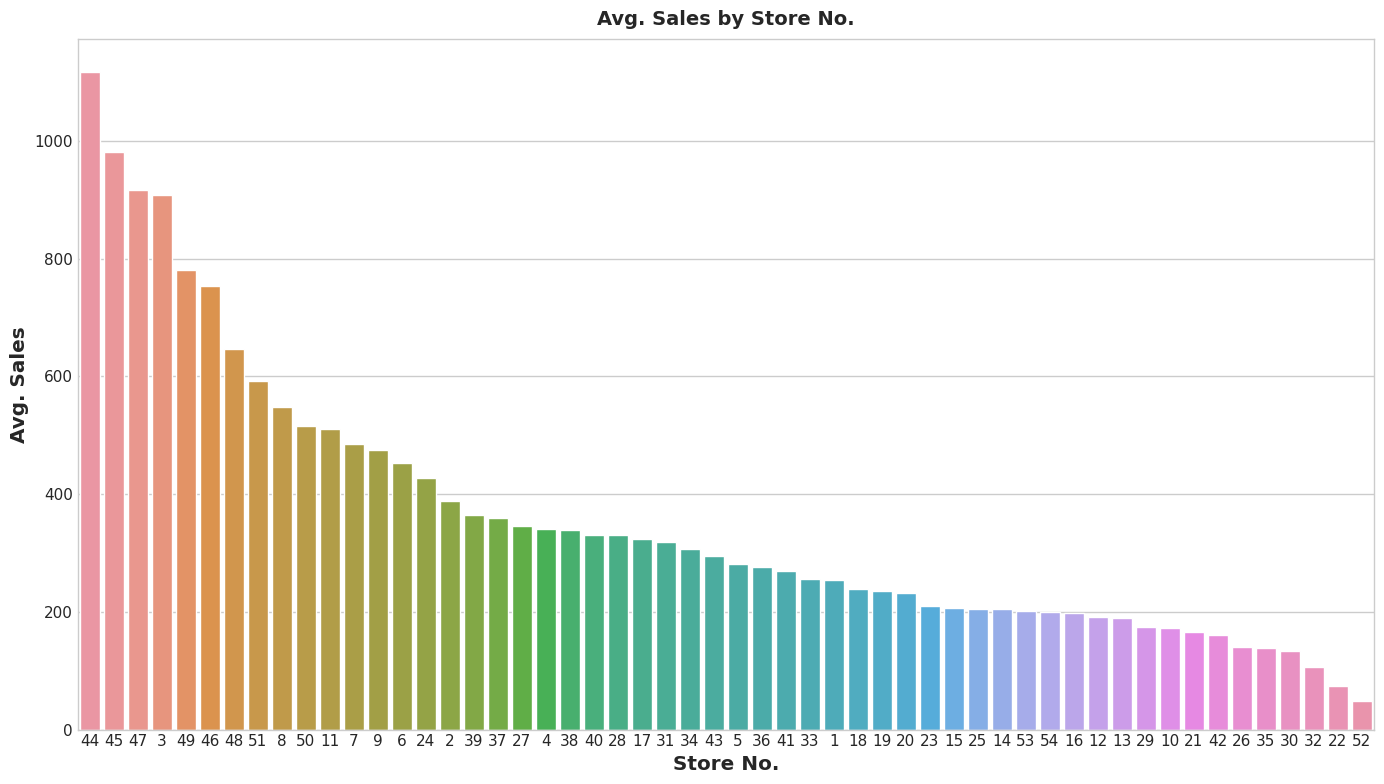

The best stores No. sell are:  [44, 45, 47, 3, 49]

The worst stores No. sell are:  [35, 30, 32, 22, 52]


In [19]:
temp=train_eda.groupby('store_nbr')['sales'].mean().sort_values(ascending=False).to_frame()

plt.figure(figsize=(14,8))
sns.barplot(data=temp,x=temp.index,y=temp.sales,ci=None,order=list(temp.index))
plt.xlabel('Store No.')
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales by Store No.')
plt.show()

print('The best stores No. sell are: ',list(temp.index[:5]))
print('\nThe worst stores No. sell are: ',list(temp.index[-5:]))

## 2.2 HOLIDAYS & EVENTS

In [20]:
display(hols_eves.info())
info(hols_eves)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


None

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


None

Dataset have: <bound method IndexOpsMixin.value_counts of Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')> columns 


===========date===========
Type is:  datetime64[ns]
date
2014-06-25    4
2017-06-25    3
2016-06-25    3
2015-06-25    3
2013-06-25    3
             ..
2014-07-13    1
2014-07-12    1
2014-07-09    1
2014-07-08    1
2017-12-26    1
Name: count, Length: 312, dtype: int64
Number of unique values of date: 312
Number of null values of date: 0



===========type===========
Type is:  object
type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64
Number of unique values of type: 6
Number of null values of type: 0



===========locale===========
Type is:  object
locale
National    174
Local       152
Regional     24
Name: count, dtype: int64
Number of unique values of locale: 3
Number of null values of locale: 0



===========locale_name===========


As described at metadata, "Pay special attention to the transferred column.
A holiday that is transferred officially falls on that calendar day, 
but was moved to another date by the government." -> get rid holidays that were transferred
and holidays that are announced a Work day, in addition to dates that are duplicated.

In [21]:
hols_eves = hols_eves.loc[(hols_eves.transferred==False) & (hols_eves.type != "Work Day")]

hols_eves = hols_eves.drop_duplicates(subset='date') # drop duplicate dates

In [22]:
avg_sales = train_eda.groupby('date')['sales'].mean().to_frame()

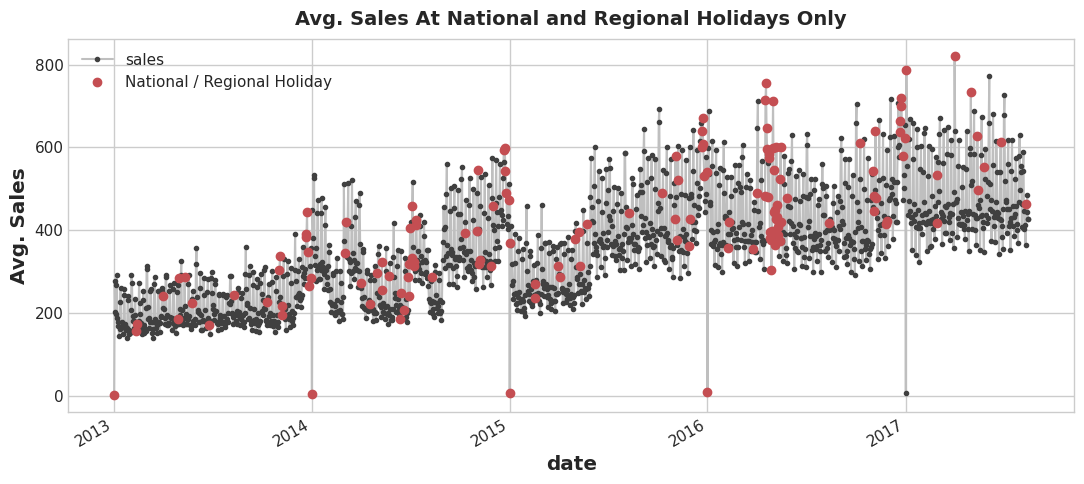

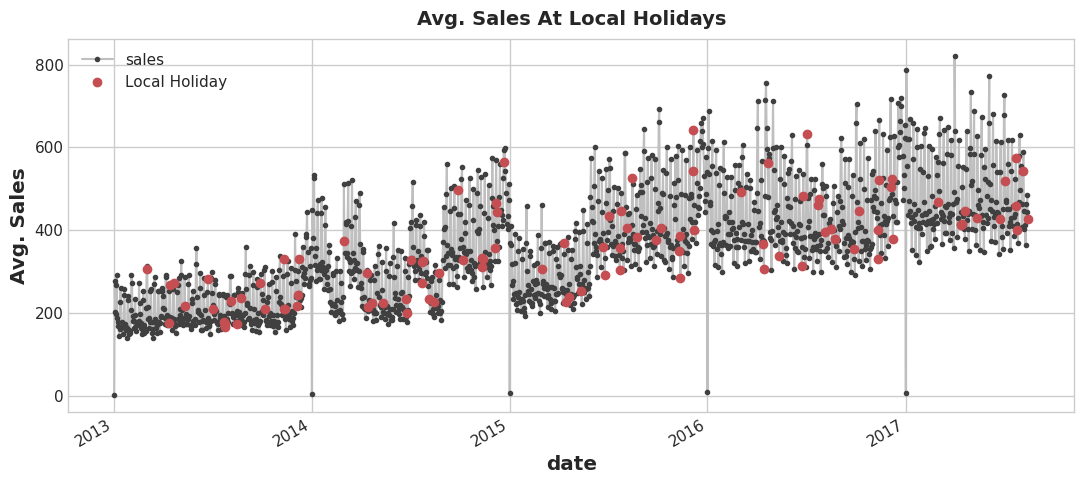

In [23]:
## National and Regional Holidays Only

NRHolidays=hols_eves.loc[hols_eves['locale']!='Local',:]
NRHolidays_avg_sales=avg_sales.reset_index().merge(NRHolidays,on='date',how='left')
x_cor=NRHolidays_avg_sales.loc[NRHolidays_avg_sales['type'].notna(),'date'].values
y_cor=NRHolidays_avg_sales.loc[NRHolidays_avg_sales['type'].notna(),'sales'].values
_=avg_sales['sales'].plot(**plot_params)
_=plt.plot_date(x_cor,y_cor,color='C3', label='National / Regional Holiday')
_=plt.ylabel('Avg. Sales')
_=plt.title('Avg. Sales At National and Regional Holidays Only')
_=plt.legend()

plt.show()

## LocalHolidays Only
LHolidays=hols_eves.loc[hols_eves['locale']=='Local',:]
LHolidays_avg_sales=avg_sales.reset_index().merge(LHolidays,on='date',how='left')
x_cor=LHolidays_avg_sales.loc[LHolidays_avg_sales['type'].notna(),'date'].values
y_cor=LHolidays_avg_sales.loc[LHolidays_avg_sales['type'].notna(),'sales'].values
_=avg_sales['sales'].plot(**plot_params)
_=plt.plot_date(x_cor,y_cor,color='C3', label='Local Holiday')
_=plt.ylabel('Avg. Sales')
_=plt.title('Avg. Sales At Local Holidays')
_=plt.legend()

plt.show()

Indeed, there is a differance between those three holiday types, Sales at Local holidays has no significant impact than another normal days, while sales at National/ Regional holidays are more significant for sales versus another days.

-> get rid Local holidays

In [24]:
hols_eves = hols_eves[hols_eves.locale != 'Local']

## 2.3 Oil Prices
Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In [25]:
display(oil.info())
info(oil)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


None

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


None

Dataset have: <bound method IndexOpsMixin.value_counts of Index(['date', 'dcoilwtico'], dtype='object')> columns 


===========date===========
Type is:  datetime64[ns]
date
2013-01-01    1
2016-02-08    1
2016-02-17    1
2016-02-16    1
2016-02-15    1
             ..
2014-07-22    1
2014-07-21    1
2014-07-18    1
2014-07-17    1
2017-08-31    1
Name: count, Length: 1218, dtype: int64
Number of unique values of date: 1218
Number of null values of date: 0



===========dcoilwtico===========
Type is:  float64
dcoilwtico
47.72    4
47.65    4
96.44    4
60.01    4
46.02    4
        ..
94.35    1
96.40    1
93.97    1
95.39    1
47.26    1
Name: count, Length: 998, dtype: int64
Number of unique values of dcoilwtico: 998
Number of null values of dcoilwtico: 43





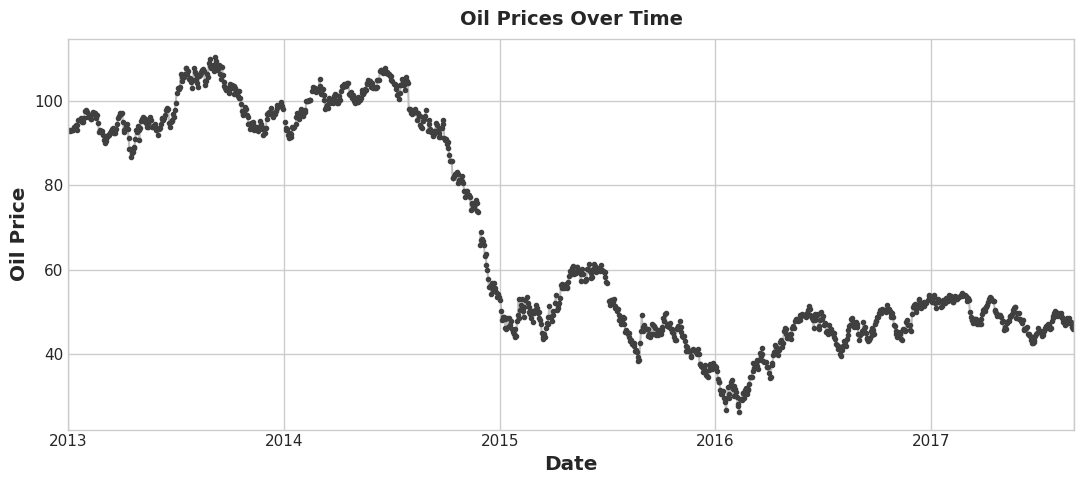

In [26]:
oil.set_index('date',inplace=True)
oil.plot(**plot_params)
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title('Oil Prices Over Time')
plt.show()

## 2.4 STORES

In [27]:
display(stores.info())
info(stores)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


None

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


None

Dataset have: <bound method IndexOpsMixin.value_counts of Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')> columns 


===========store_nbr===========
Type is:  int64
store_nbr
1     1
41    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
42    1
2     1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
29    1
28    1
27    1
26    1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
54    1
Name: count, dtype: int64
Number of unique values of store_nbr: 54
Number of null values of store_nbr: 0



===========city===========
Type is:  object
city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja      

In [28]:
avg_sales=train_eda.groupby('store_nbr')['sales'].mean().reset_index()

stores=stores.merge(avg_sales,on='store_nbr',how='left')

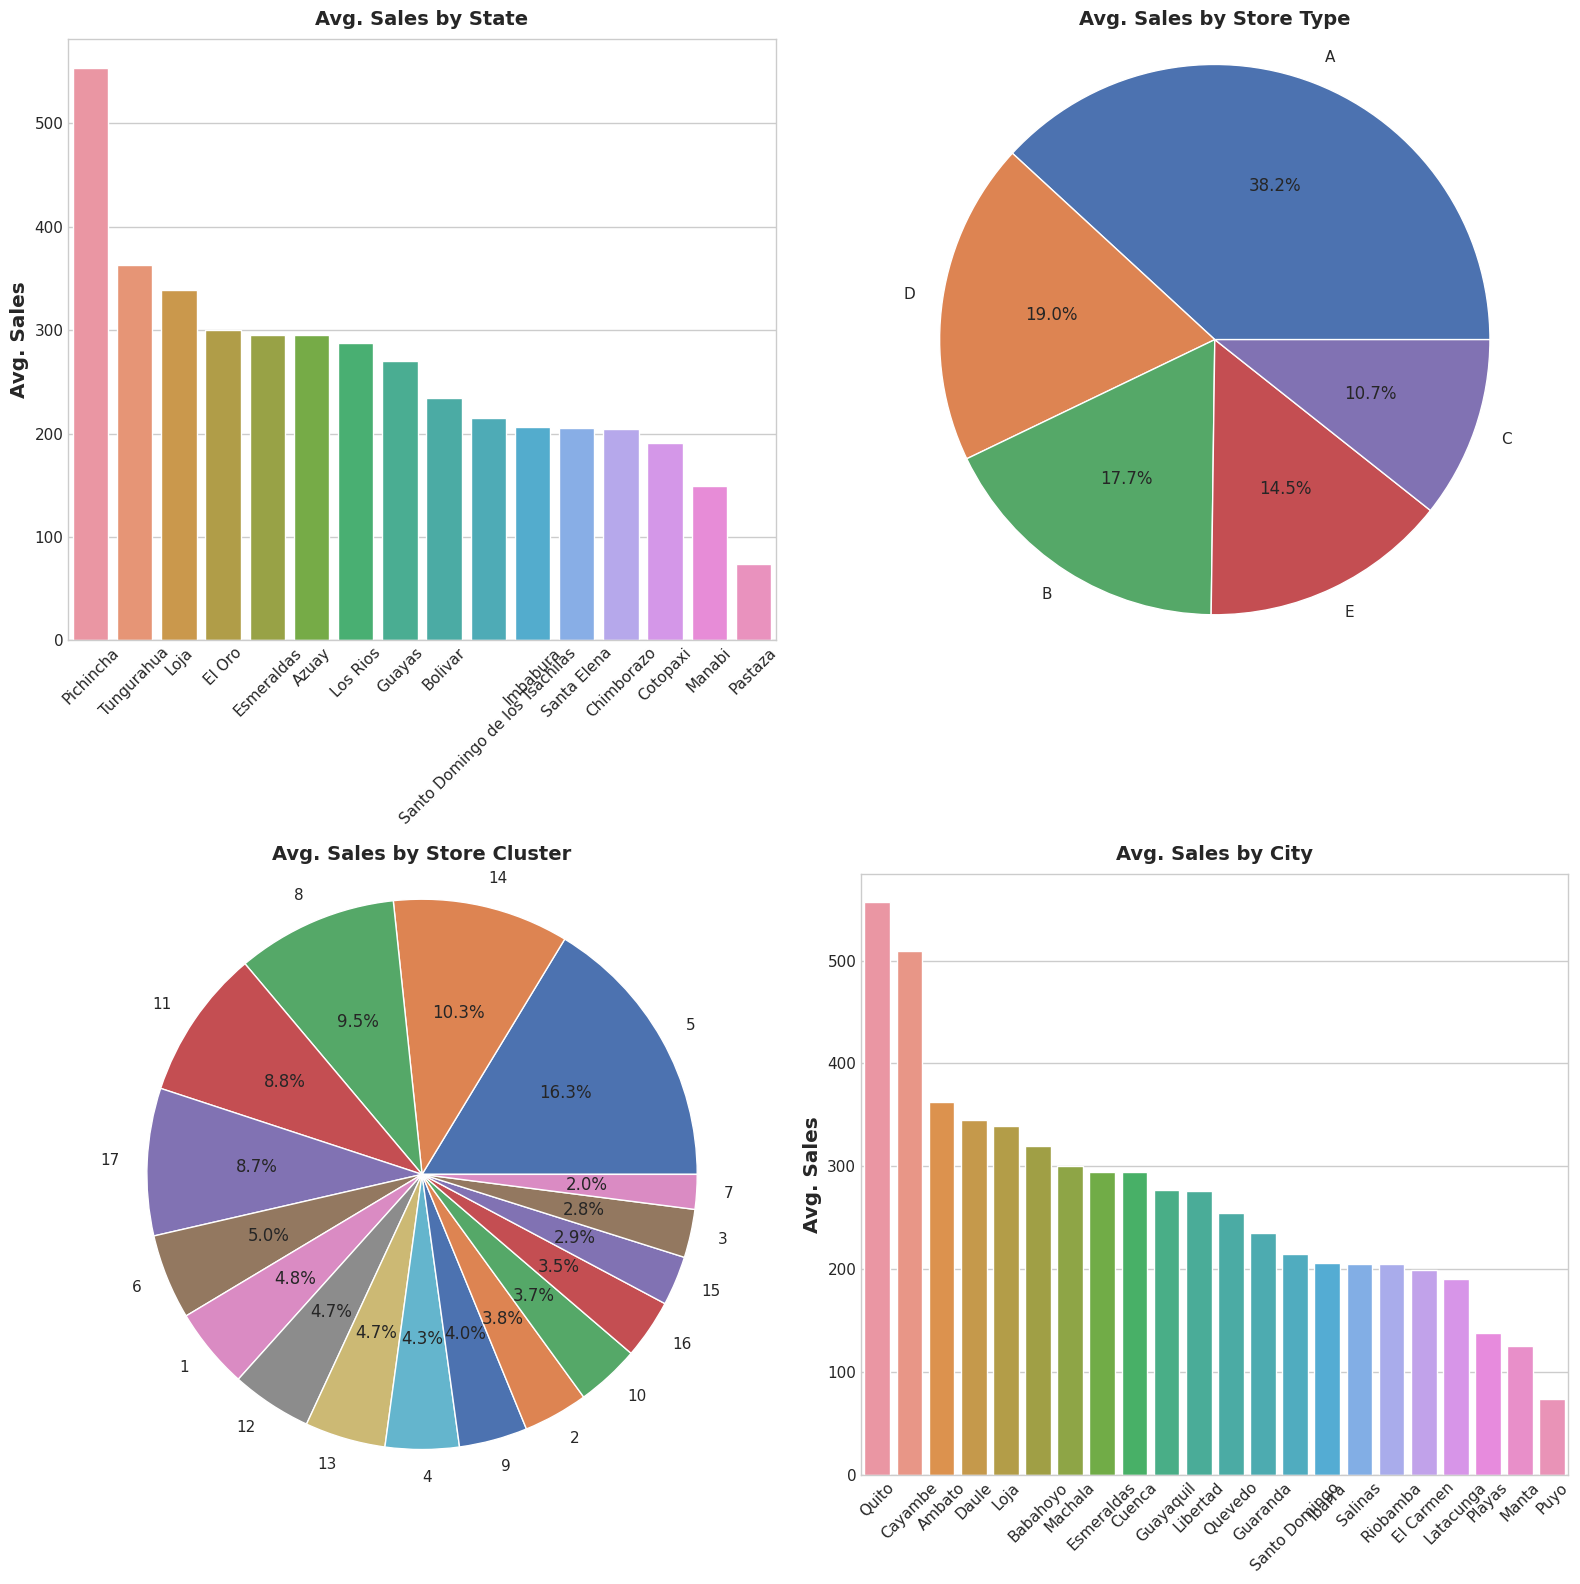

In [29]:
plt.figure(figsize=(16,16))

plt.subplot(2,2,1) ## Avg. Sales by State Chart
state_grouped=stores.groupby('state')['sales'].mean().sort_values(ascending=False)
sns.barplot(x=state_grouped.index, y=state_grouped.values,
           ci=None, order=list(state_grouped.index))
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales by State')

plt.subplot(2,2,2)
type_grouped=stores.groupby('type')['sales'].mean().sort_values(ascending=False)
plt.pie(type_grouped, labels=type_grouped.index, autopct="%1.1f%%")
plt.axis('equal')
plt.title('Avg. Sales by Store Type')

plt.subplot(2,2,3)
cluster_grouped=stores.groupby('cluster')['sales'].mean().sort_values(ascending=False)
plt.pie(cluster_grouped, labels=cluster_grouped.index, autopct="%1.1f%%")
plt.axis('equal')
plt.title('Avg. Sales by Store Cluster')

plt.subplot(2,2,4)
city_grouped=stores.groupby('city')['sales'].mean().sort_values(ascending=False)
sns.barplot(x=city_grouped.index, y=city_grouped.values,
           ci=None, order=list(city_grouped.index))
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales by City')

plt.show()

- The best States sells are ( Pichincha, Tungurahua, Loja ), while the worst are ( Cotopaxi, Manabi, Pastaza ).

- The best Cities sells are ( Quito, Cayambe, Ambato ), while the worst are ( Playas, Manta, Puyo ).

- The best Store Clusters sells are (5, 14, 8, 11), while the worst are (7, 3, 15, 16).

- The order of best Store Type is: A -> D -> B -> E -> C.

All of these variable have impact on Favorita Supermarkets sales, So thew will be used in trainig.



In [30]:
# Converting dtype for store variables to category for simplification

stores['type'] = pd.Categorical(stores['type'], categories=type_grouped.index[::-1], ordered=True)

stores['cluster']=pd.Categorical(stores['cluster'], categories=cluster_grouped.index[::-1], ordered=True)

stores['state']=pd.Categorical(stores['state'], categories=state_grouped.index[::-1], ordered=True)

stores['city']=pd.Categorical(stores['city'], categories=city_grouped.index[::-1], ordered=True)

stores.drop('sales', axis=1, inplace=True)

## 2.5 TRANSACTIONS
Transactions means how many people came to the store or how many invoices created in a day.

This feature is highly correlated with sales

Sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

### 2.5.1 Transactions

In [31]:
info(transactions)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


None

Dataset have: <bound method IndexOpsMixin.value_counts of Index(['date', 'store_nbr', 'transactions'], dtype='object')> columns 


===========date===========
Type is:  datetime64[ns]
date
2017-08-15    54
2017-06-02    54
2017-05-21    54
2017-05-22    54
2017-05-23    54
              ..
2016-01-04    14
2014-01-01     2
2017-01-01     1
2015-01-01     1
2013-01-01     1
Name: count, Length: 1682, dtype: int64
Number of unique values of date: 1682
Number of null values of date: 0



===========store_nbr===========
Type is:  int64
store_nbr
39    1678
38    1678
26    1678
31    1678
33    1678
34    1678
37    1678
27    1677
28    1677
32    1677
23    1677
40    1677
41    1677
44    1677
45    1677
46    1677
47    1677
48    1677
50    1677
51    1677
49    1677
2     1677
16    1677
5     1677
54    1676
3     1676
4     1676
6     1676
8     1676
9     1676
19    1676
35    1676
13    1676
1     1676
15    1676
11    1676
10    1675
7     1675
17    1674
43    1672
30    1655
14

### 2.5.2 Total sales & Transactions

The correaltion between total sales & transactions is: 0.8374 n


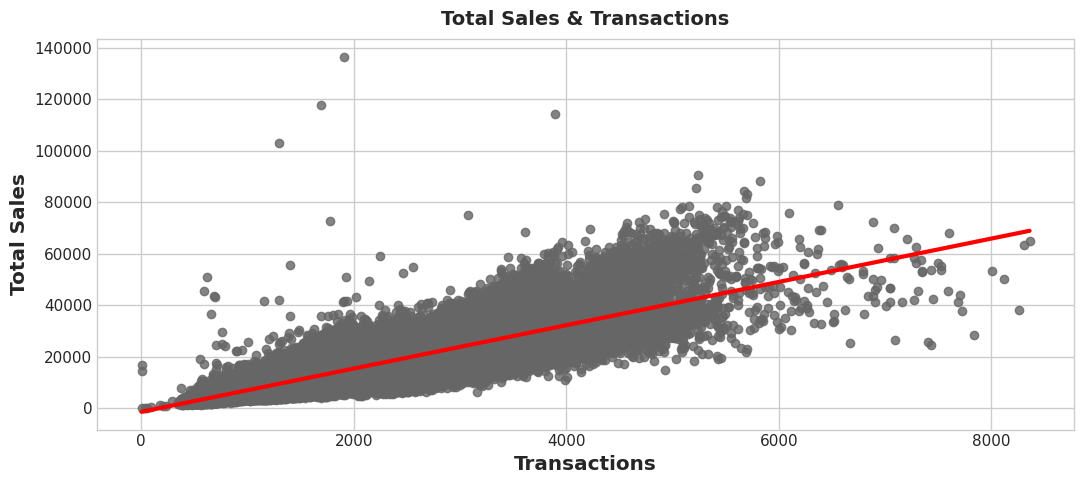

In [32]:
avg_sales = train_eda.groupby(['date', 'store_nbr'])['sales'].sum().reset_index() # grouping by store_nbr

temp = pd.merge(avg_sales, transactions, how = "left")

print('The correaltion between total sales & transactions is:', np.round(temp[['sales', 'transactions']].corr().iloc[0,1],4), 'n')

# plotting
sns.regplot(data=temp, x='transactions', y='sales', ci=None, scatter_kws={'color':'0.4'}, line_kws={'color':'red', 'linewidth':3})
plt.xlabel('Transactions')
plt.ylabel('Total Sales')
plt.title('Total Sales & Transactions')
plt.show()

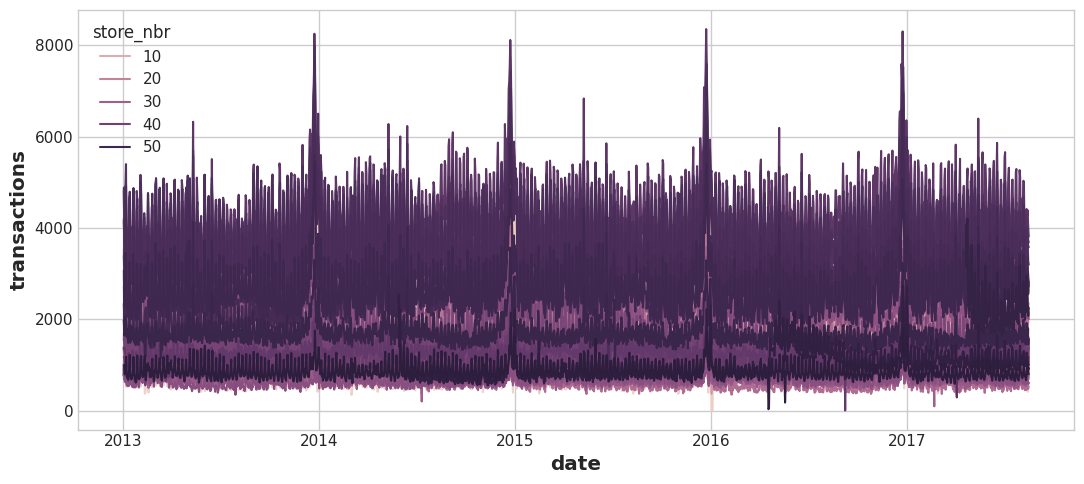

In [33]:
sns.lineplot(data=temp, x='date', y='transactions', hue='store_nbr')
plt.show()

There is a stable pattern in Transaction. All months are similar except December from 2013 to 2017.

Store sales had always increased at the end of the year.

Transactions will be used in training as well.

## 2.8 Determine Trend
Let's make a moving average plot to see what kind of trend this series has. Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

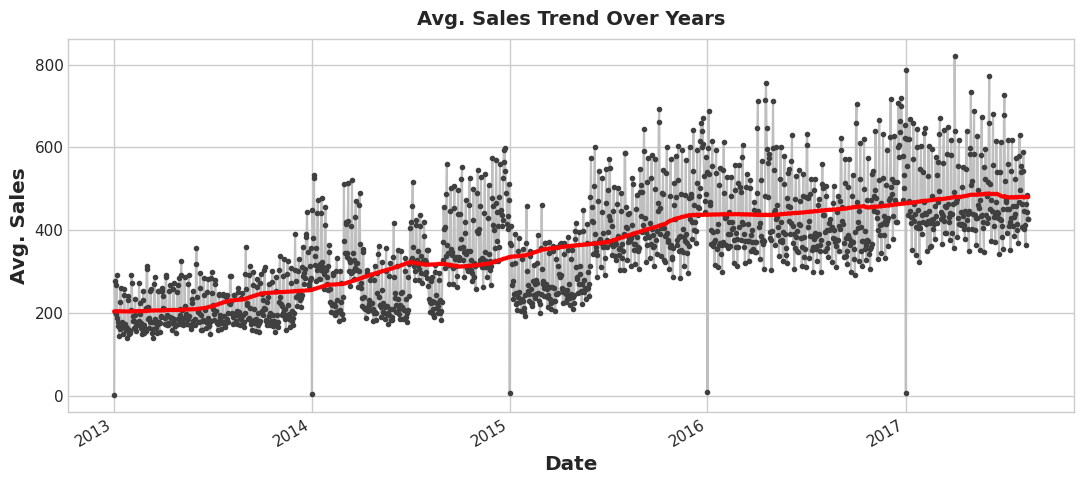

In [34]:
avg_sales=train_eda.groupby('date').sales.mean()
moving_avg=avg_sales.rolling(window=365,min_periods=183,center=True).mean()

ax=avg_sales.plot(**plot_params)
ax=moving_avg.plot(color='red',linewidth=3)
plt.xlabel('Date')
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales Trend Over Years')
plt.show()

## 2.8 Determine Seasonality
We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series.

Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

In [35]:
def seasonal_plot(X, y, period, freq):
    """
    This defination is to plot seasonal fluctuation in a time series to discover seasonal patterns.
    Inputs:
            X: time series.
            y: target variables 
            period: The period of time series
            freq: The frequency to plot time seris for it
    Output:
        Time Series Seasonal Plot    
    """
    _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ci=False, ax=ax,
                      palette=palette, legend=False)
    
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(),size=14,
                    xycoords=ax.get_yaxis_transform(), textcoords="offset points",va="center")
        
    return ax


def plot_periodogram(ts):
    """
    This defination is to discover seasonality and plot the periodogram for a time series. 
    """
    
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend='linear', window="boxcar",scaling='spectrum')
    
    _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        ["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)",
         "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"], rotation=30)
    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    
    return ax

<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

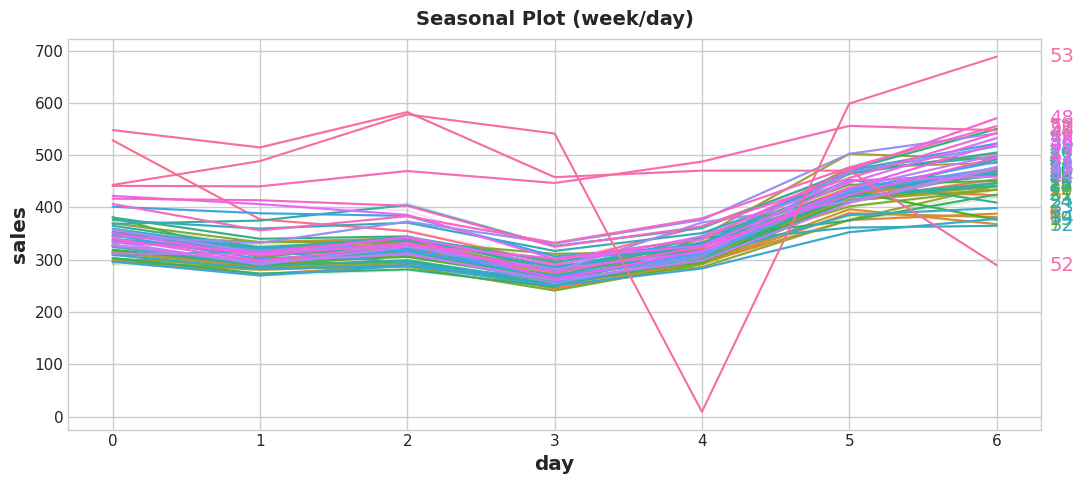

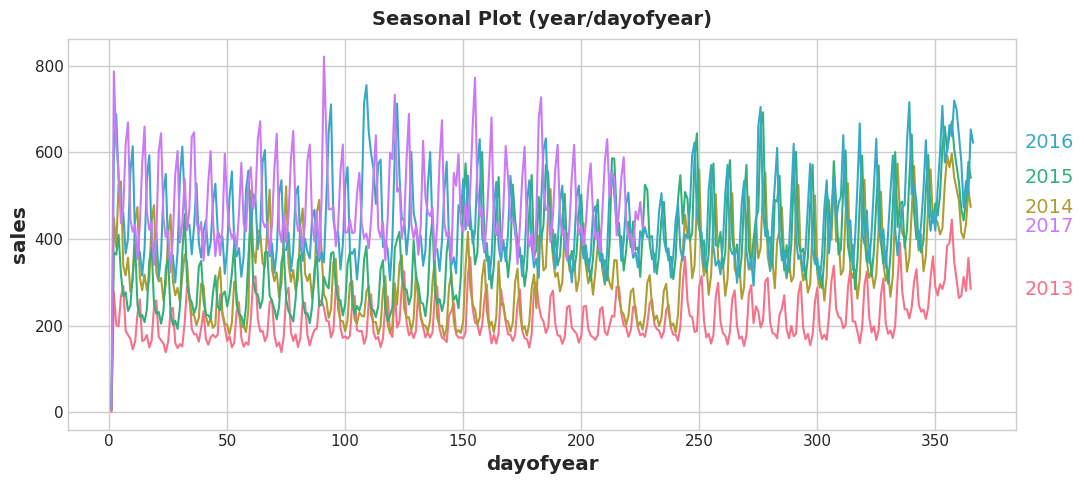

In [36]:
avg_sales = train_eda.groupby('date')['sales'].mean().to_frame()

# days within a week
avg_sales["day"] = avg_sales.index.dayofweek  # the x-axis (freq)
avg_sales["week"] = avg_sales.index.isocalendar().week  # the seasonal period (period)

# days within a year
avg_sales["dayofyear"] = avg_sales.index.dayofyear
avg_sales["year"] = avg_sales.index.year

seasonal_plot(avg_sales, y=avg_sales['sales'], period="week", freq="day")
seasonal_plot(avg_sales, y=avg_sales['sales'], period="year", freq="dayofyear")

Now let's look at the periodogram:

# 3. Data processing

In [37]:
# train dataset from large to wide
# because of prediction is for only 16 days, I'll use data from 2017 only

store_sales = train.drop('id', axis=1).set_index(['store_nbr','family','date'])

family_sales = store_sales.drop('onpromotion', axis=1).unstack(['store_nbr', 'family']).loc['2017']

family_sales.index = family_sales.index.to_period('D')

## 3.2 Log transform Sales

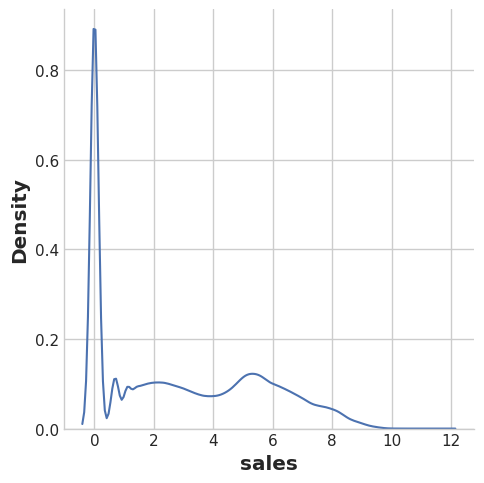

In [38]:
# log transform train['sales']
train.sales = np.log1p(train['sales'])

sns.displot(train, x='sales', kind='kde');

## 3.3 Create Seasonal Features
I selected only 2017 year for prediction of 16 days, so I will use DeterministicProcess and CalendarFourier to create:

Indicators for weekly seasons.

Linear order of trend.

Fourier features of order 4 for monthly seasons.

In [39]:
y = family_sales.loc(axis=1)['sales']
fourier = CalendarFourier(freq='M', order=4) ## Fourier features of order 4 for monthly seasons
dp =  DeterministicProcess(index = y.index, seasonal = True,  
                          order = 1, additional_terms = [fourier], drop = True)
X_train_1 = dp.in_sample()

## 3.4 Holiday Effect

In [40]:
## Drop Transferred & Workday Holidays
hols_eves= hols_eves.loc[(hols_eves.transferred==False) & (hols_eves.type != 'Work Day') & (hols_eves.locale != 'Local')]

## Drop Duplicated Holiday Days:
hols_eves.drop_duplicates('date', inplace=True)
hols_eves = hols_eves[['date','type']] ## Keep date & holiday type for merging

## Merging and Mapping:
X_train_1.index = X_train_1.index.to_timestamp()
X_train_1=X_train_1.reset_index().merge(hols_eves,on='date',how='left')
X_train_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_train_1['is_holiday']=X_train_1.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_train_1['is_holiday']=X_train_1['is_holiday'].fillna(0).astype('int8')

## Adding weekends to holiday as well
X_train_1['day_of_week'] = X_train_1.date.dt.day_of_week.astype('int8')
X_train_1.loc[(X_train_1['day_of_week']==5) | (X_train_1['day_of_week']==6), 'is_holiday'] = 1
X_train_1.drop('day_of_week',axis=1, inplace=True)

## Removing the first day of a year from holidays.
X_train_1['start_of_year']= (X_train_1.date.dt.dayofyear ==1)
X_train_1.loc[X_train_1['start_of_year']==True, 'is_holiday']=0
X_train_1['start_of_year'] = X_train_1['start_of_year'].astype('int8')

X_train_1 = X_train_1.set_index('date')
X_train_1.index = X_train_1.index.to_period('D')

# 4. Fit/Predict dèinitions for hybrid models

In [41]:
def fit(model_1, model_2, X_train_1, X_train_2, y):

    """
    Defination for hyprid models fitting.
    Inputs: 
    -   modeal_1: the 1st model.
    -   model_2: the 2nd model.
    -   X_train_1: training data for model_1.
    -   X_train_2: trainng data fro model_2.
    -   y: target of training data of model_1.
    Output:
    -   Hyprid models fitting.
    """
    
    model_1.fit(X_train_1,y)

    # Make predictions with model_1
    y_fit = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns)

    y_resid = y - y_fit # compute residuals
    y_resid = y_resid.unstack().reset_index(['store_nbr','family','date']) # wide to long
    y_resid['date'] = y_resid['date'].dt.to_timestamp()
    y_resid = y_resid.set_index(['store_nbr','family','date'])
    y_resid.rename({0:'residuals'},axis=1,inplace=True)
    
    # re-order the index of y_resid as the index of X_train_2
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_resid = y_resid.reindex(new_index.index)
    
    y_resid.reset_index(['store_nbr','family'], drop=True, inplace=True) # drop unneccessary varibales
    
    model_2.fit(X_train_2, y_resid)

def predict(model_1, model_2, X_train_1, X_train_2):
    
    """
    Defination for hyprid models prediction.
    Inputs: 
    -   modeal_1: the 1st model (fiited).
    -   model_2: the 2nd model (fiited).
    -   X_train_1: training data for model_1.
    -   X_train_2: trainng data fro model_2.
    Output:
    -   y_pred: final prediction of hyprid models.
    """
    
    global y 
    y_pred = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns) # prediction of 1st model

    y_pred = y_pred.unstack().reset_index(['store_nbr','family','date']) # wide to long
    y_pred['date'] = y_pred['date'].dt.to_timestamp()
    y_pred = y_pred.set_index(['store_nbr','family','date'])
    y_pred.rename({0:'sales'},axis=1,inplace=True)
    
    # re-order the index of y_pred as the index of X_train_2
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_pred = y_pred.reindex(new_index.index)
    
    values = y_pred['sales'].values
    sales = model_2.predict(X_train_2) + values
    y_pred['sales'] = sales.clip(0.0)  ## clipping values < 0 to 0.0
    
    return y_pred 

# 5. Hyprid models training/prediction


In [42]:
model_1 = LinearRegression() 

model_2 = CatBoostRegressor(silent= True) ## by default hyperparameter

# X_train_2: Features for CatBoost
X_train_2 = train.drop(['id','sales'],axis=1).set_index('date').loc['2017']

# Label encoding for 'family'
le = LabelEncoder()
X_train_2['family'] = le.fit_transform(X_train_2['family'])

X_train_2['start_of_year']= (X_train_2.index.dayofyear ==1).astype('int8')


fit(model_1, model_2, X_train_1, X_train_2, y)

y_pred= predict(model_1, model_2, X_train_1, X_train_2)

# Hyper models evaluation

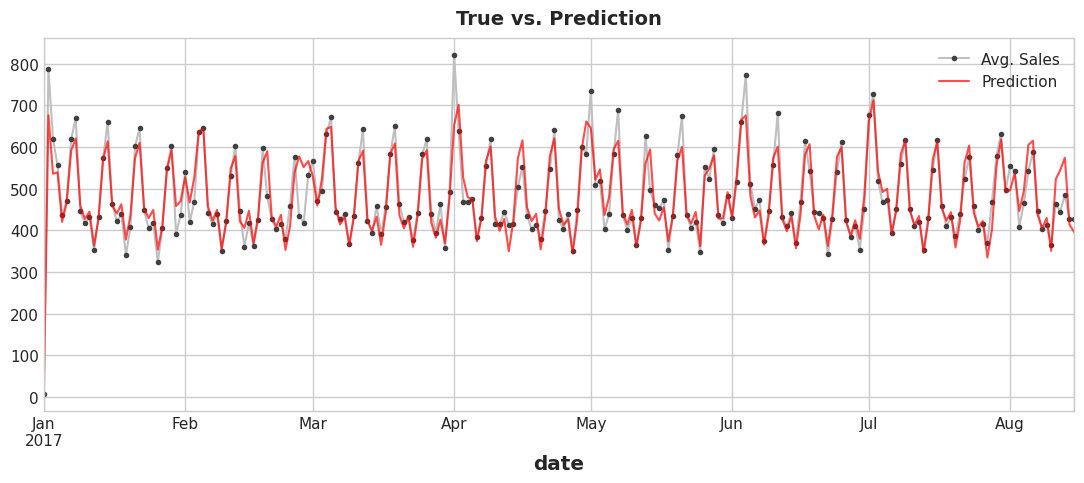

In [43]:
ax=y.mean(axis=1).plot(**plot_params, label='Avg. Sales', title='True vs. Prediction')
ax=y_pred.groupby('date')['sales'].mean().plot(color='red', alpha=0.7, label='Prediction', legend=True)
ax=plt.legend()
plt.show()

# Test data preparation

In [44]:
X_test_1 = dp.out_of_sample(steps = 16) # 16 because we are predicting next 16 days
X_test_1.index = X_test_1.index.rename('date').to_timestamp()

## Merging and Mapping:
X_test_1=X_test_1.reset_index().merge(hols_eves,on='date',how='left').set_index('date')
X_test_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_test_1['is_holiday']=X_test_1.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_test_1['is_holiday']=X_test_1['is_holiday'].fillna(0).astype('int8')

## Adding weekends to holiday as well
X_test_1['day_of_week'] = X_test_1.index.day_of_week.astype('int8')
X_test_1.loc[(X_test_1['day_of_week']==5) | (X_test_1['day_of_week']==6), 'is_holiday'] = 1
X_test_1.drop('day_of_week',axis=1, inplace=True)

## Removing the first day of a year from holidays as mentioned before Favorita is closed these days.
X_test_1['start_of_year']= (X_test_1.index.dayofyear ==1)
X_test_1.loc[X_test_1['start_of_year']==True, 'is_holiday']=0
X_test_1['start_of_year'] = X_test_1['start_of_year'].astype('int8')
X_test_1.index = X_test_1.index.to_period('D')

X_test_2=test.set_index('date')
X_test_2 = X_test_2.drop('id', axis = 1)
X_test_2['start_of_year']= (X_test_2.index.dayofyear ==1).astype('int8')
X_test_2['family'] = le.transform(test['family'])

In [45]:
target = predict(model_1, model_2, X_test_1, X_test_2)

# Submission

In [46]:
submission=pd.read_csv(path+'sample_submission.csv')
submission['sales']=target.reset_index()['sales']
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [47]:
submission.head()

,id,sales
0,3000888,5.287306
1,3000889,1.214243
2,3000890,5.205849
3,3000891,2262.968552
4,3000892,0.755602
